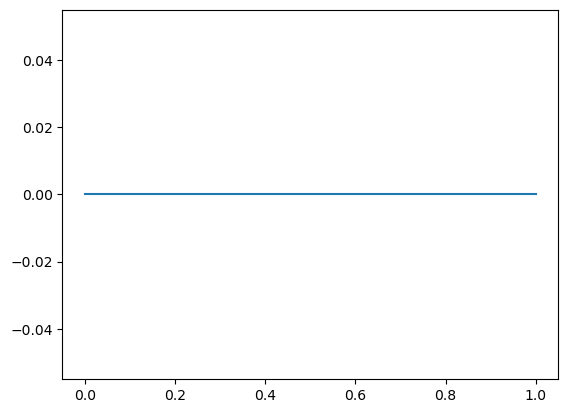

In [ ]:
import numpy as np
from astropy.io import fits
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyproj
import scipy.spatial.transform as te
import pymap3d
#mpl.use('Tkagg')

**Below is the conversion from ECEF to ENU**

In [4]:
def convert_ecef2enu(x,y,z,lat0, lon0, alt0):
    transformer = pyproj.Transformer.from_crs({"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
                                {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},)
    x_org, y_org, z_org = transformer.transform(lon0,lat0,alt0,radians=False)
    vec=np.array([[ x-x_org, y-y_org, z-z_org]]).T
    rot1 =  te.Rotation.from_euler('x', -(90-lat0), degrees=True).as_matrix()#angle*-1 : left handed *-1
    rot3 =  te.Rotation.from_euler('z', -(90+lon0), degrees=True).as_matrix()#angle*-1 : left handed *-1
    rotMatrix = rot1.dot(rot3)
    enu = rotMatrix.dot(vec).T.ravel()
    print(x_org, y_org, z_org, enu.T)
    return enu.T

def enu2geodetic(x,y,z, lat_org, lon_org, alt_org):
    transformer1 = pyproj.Transformer.from_crs(
        {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
        {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
        )
    transformer2 = pyproj.Transformer.from_crs(
        {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
        {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
        )
    
    x_org, y_org, z_org = transformer1.transform( lon_org,lat_org,  alt_org,radians=False)
    ecef_org=np.array([[x_org,y_org,z_org]]).T
    print(ecef_org)

a=convert_ecef2enu(5109058.063,2007302.436,-3239167,-3.072110999999999947e+01, 2.141110000000000113e+01, 1095)
print('a:',a)
enu2geodetic(a[0],a[1],a[2], -3.072110999999999947e+01, 2.141110000000000113e+01, 1095)
#ell_clrk66 = pymap3d.Ellipsoid('WGS84')
lat1, lon1, h1 = pymap3d.enu2geodetic(a[0],a[1],a[2], \
                                      -3.072110999999999947e+01, 2.141110000000000113e+01, 1095, \
                                      deg=True)
print(lat1, lon1, h1)

5109984.33090823 2003723.054191447 -3239910.8846445885 [3.67049189e+03 8.66484944e+02 1.96015269e+00]
a: [3.67049189e+03 8.66484944e+02 1.96015269e+00]
[[ 5109984.33090823]
 [ 2003723.05419145]
 [-3239910.88464459]]
-30.713289993804004 21.449412002048188 1098.0742848111854


## SKA Sensitivity Calculations

## Simulation Code

In [3]:
obs = ['snap','long']
path = '/media/rohit/sdata/ska-solar-files/sim/'
aa=fits.open(path+'20151203_240MHz_psimas.fits')
freq_array = np.array([50,100,200,300,500,1000,1500,2000])
solar_model = [0]* 8
solar_map=aa[0].data
for i in range(8):
    solar_model[i]=solar_map/np.nanmax(solar_map)*20*1.e4*(freq_array[i]*1.e6/2.4e8)**2
solar_model = np.array(solar_model)
npix_per_beam_mwa = 27
npix_per_beam_meerkat = 2
npix_per_beam_skalow = 2
npix_per_beam_skamid = 4

do_Tbarray_loop = 0
if(do_Tbarray_loop):
    Tbarray_mwa_snap = [0]*3
    Tbarray_mwa_long = [0]*3
    Tbarray_meerkat_snap = [0]*3
    Tbarray_meerkat_long = [0]*3
    Tbarray_skalow_snap = [0]*3
    Tbarray_skalow_long = [0]*3
    Tbarray_skamid_snap = [0]*3
    Tbarray_skamid_long = [0]*3
    for m in range(3): # No Source / Point Source / Point Array
        Tbarray_mwa_snap[m] = [0]*4
        Tbarray_mwa_long[m] = [0]*4
        Tbarray_meerkat_snap[m] = [0]*4
        Tbarray_meerkat_long[m] = [0]*4
        Tbarray_skalow_snap[m] = [0]*4
        Tbarray_skalow_long[m] = [0]*4
        Tbarray_skamid_snap[m] = [0]*4
        Tbarray_skamid_long[m] = [0]*4
        for f in range(4):
            fname_mwa_snap = path+'solar_mwa_snap'+str(m)+'_'+str(freq_array[f])+'MHz.fits'
            d,h=fits.getdata(fname_mwa_snap,header=True)
            Tbarray_mwa_snap[m][f] = d[0][0]/(np.pi*npix_per_beam_mwa**2)/1.e4
            fname_mwa_long = path+'solar_mwa_long'+str(m)+'_'+str(freq_array[f])+'MHz.fits'
            d,h=fits.getdata(fname_mwa_long,header=True)
            Tbarray_mwa_long[m][f] = d[0][0]/(np.pi*npix_per_beam_mwa**2)/1.e4
            fname_skalow_snap = path+'solar_skalow_snap'+str(m)+'_'+str(freq_array[f])+'MHz.fits'
            d,h=fits.getdata(fname_skalow_snap,header=True)
            Tbarray_skalow_snap[m][f] = d[0][0]/(np.pi*npix_per_beam_skalow**2)/1.e4
            fname_skalow_long = path+'solar_skalow_long'+str(m)+'_'+str(freq_array[f])+'MHz.fits'        
            d,h=fits.getdata(fname_skalow_long,header=True)
            Tbarray_skalow_long[m][f] = d[0][0]/(np.pi*npix_per_beam_skalow**2)/1.e4

        for f in range(4):
            fname_meerkat_snap = path+'solar_meerkat_snap'+str(m)+'_'+str(freq_array[4+f])+'MHz.fits'
            fname_meerkat_long = path+'solar_meerkat_long'+str(m)+'_'+str(freq_array[4+f])+'MHz.fits'
            fname_skamid_snap = path+'solar_skamid_snap'+str(m)+'_'+str(freq_array[4+f])+'MHz.fits'
            fname_skamid_long = path+'solar_skamid_long'+str(m)+'_'+str(freq_array[4+f])+'MHz.fits'
            d,h=fits.getdata(fname_meerkat_snap,header=True)
            Tbarray_meerkat_snap[m][f] = d[0][0]/(np.pi*npix_per_beam_meerkat**2)/1.e4
            d,h=fits.getdata(fname_meerkat_long,header=True)
            Tbarray_meerkat_long[m][f] = d[0][0]/(np.pi*npix_per_beam_meerkat**2)/1.e4
            d,h=fits.getdata(fname_skamid_snap,header=True)
            Tbarray_skamid_snap[m][f] = d[0][0]/(np.pi*npix_per_beam_skamid**2)/1.e4        
            d,h=fits.getdata(fname_skamid_long,header=True)
            Tbarray_skamid_long[m][f] = d[0][0]/(np.pi*npix_per_beam_skamid**2)/1.e4

Tbarray_mwa_snap = np.array(Tbarray_mwa_snap)
Tbarray_mwa_long = np.array(Tbarray_mwa_long)
Tbarray_meerkat_snap = np.array(Tbarray_meerkat_snap)
Tbarray_meerkat_long = np.array(Tbarray_meerkat_long)
Tbarray_skalow_snap = np.array(Tbarray_skalow_snap)
Tbarray_skalow_long = np.array(Tbarray_skalow_long)
Tbarray_skamid_snap = np.array(Tbarray_skamid_snap)
Tbarray_skamid_long = np.array(Tbarray_skamid_long)
Tbarray_skamid_long.shape

print('Writing...')
Tbsnap = np.array((Tbarray_mwa_snap,Tbarray_skalow_snap,Tbarray_meerkat_snap,Tbarray_skamid_snap))
Tblong = np.array((Tbarray_mwa_long,Tbarray_skalow_long,Tbarray_meerkat_long,Tbarray_skamid_long))
print(Tbsnap.shape)
np.save(path+'TB_SNAP.p',Tbsnap)
np.save(path+'TB_LONG.p',Tblong)


NameError: name 'Tbarray_mwa_snap' is not defined

In [4]:

# mwa,skalow,meerkat,skamid / three point source / frequency
Tbarray_snap = np.load(path+'TB_SNAP.p.npy',allow_pickle=True)
Tbarray_long = np.load(path+'TB_LONG.p.npy',allow_pickle=True)
flux_max_snap = np.max(Tbarray_snap,axis=(3,4))
flux_max_long = np.max(Tbarray_long,axis=(3,4))

off_disk_std_snap = np.std(Tbarray_snap[:,:,:,0:500,:],axis=(3,4))
off_disk_std_long = np.std(Tbarray_long[:,:,:,0:500,:],axis=(3,4))
on_disk_std_snap = np.std(Tbarray_snap[:,:,:,900:1200,:],axis=(3,4))
on_disk_std_long = np.std(Tbarray_long[:,:,:,900:1200,:],axis=(3,4))

DR_off_snap = flux_max_snap/off_disk_std_snap
DR_off_long = flux_max_long/off_disk_std_long
DR_on_snap = flux_max_snap/on_disk_std_snap
DR_on_long = flux_max_long/on_disk_std_long
print(off_disk_std_long.shape)

(4, 3, 4)


In [4]:
f,(ax0) = plt.subplots(1,1)
ax0.plot(freq_array[0:4] , off_disk_std_snap[0,0], color='r', linestyle='-', label ='Off-disk / No Source')
ax0.plot(freq_array[0:4] , off_disk_std_snap[0,1], color='g', linestyle='-', label ='Off-disk / Point Source')
ax0.plot(freq_array[0:4] , off_disk_std_snap[0,2], color='b', linestyle='-', label ='Off-disk / 100 Sources')
#ax0.plot(freq_array[0:4] , on_disk_std_snap[0,0], color='r', linestyle='--', label ='On-disk / No Source')
#ax0.plot(freq_array[0:4] , on_disk_std_snap[0,1], color='g', linestyle='--', label ='On-disk / Point Source')
#ax0.plot(freq_array[0:4] , on_disk_std_snap[0,2], color='b', linestyle='--', label ='On-disk / 100 Sources')
ax0.legend()
plt.show()


In [5]:
f,(ax0) = plt.subplots(1,1)
ax0.plot(freq_array[0:4] , off_disk_std_snap[0,0], color='r', linestyle='-', label ='Off-disk / MWA')
ax0.plot(freq_array[0:4] , off_disk_std_snap[1,0], color='g', linestyle='-', label ='Off-disk / SKA-low')
ax0.legend()
plt.show()

f,(ax0) = plt.subplots(1,1)
ax0.plot(freq_array[0:4] , flux_max_snap[0,0], color='r', linestyle='-', label ='Off-disk / MWA')
ax0.plot(freq_array[0:4] , flux_max_snap[1,0], color='g', linestyle='-', label ='Off-disk / SKA-low')
ax0.legend()
plt.show()

In [6]:
f,ax0 = plt.subplots(1,1)
ax0.plot(freq_array[0:4] , DR_off_long[0,0], color='r', linestyle='-', label ='Off-disk DR (MWA)')
ax0.plot(freq_array[0:4] , DR_off_long[1,0], color='g', linestyle='-', label ='Off-disk DR (SKA-low)')
ax0.set_title('MWA')
ax0.legend()
ax0.set_ylabel('Flux density (SFU)')
ax0.set_xlabel('Frequency (MHz)')
ax0.set_yscale('log')
plt.show()

invalid command name "128297255273600process_stream_events"
    while executing
"128297255273600process_stream_events"
    ("after" script)
can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


In [7]:

f,ax0 = plt.subplots(1,1)
ax0.plot(freq_array[4:] , DR_off_snap[3,0], color='r', linestyle='-', label ='Off-disk DR (snap)')
ax0.plot(freq_array[4:] , DR_off_long[3,0], color='b', linestyle='-', label ='Off-disk DR (long)')
ax0.plot(freq_array[4:] , DR_on_snap[3,0], color='r', linestyle='--', label ='On-disk DR (snap)')
ax0.plot(freq_array[4:] , DR_on_long[3,0], color='b', linestyle='--', label ='On-disk DR (long)')
ax0.set_title('SKA-mid')
ax0.legend()
ax0.set_ylabel('Flux density (SFU)')
ax0.set_xlabel('Frequency (MHz)')
ax0.set_yscale('log')
ax0.set_ylim([1.e0,1.e3])
plt.show()

invalid command name "128294995096576process_stream_events"
    while executing
"128294995096576process_stream_events"
    ("after" script)
can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


In [6]:

f,ax0 = plt.subplots(1,1)
ax0.plot(freq_array[0:4] , flux_max_snap[0][0],'o-',label = 'No Point Source')
ax0.plot(freq_array[0:4] , flux_max_snap[0][1],'o-',label = 'Point Source')
ax0.plot(freq_array[0:4] , flux_max_snap[0][2],'o-',label = '100 Sources')
ax0.set_xlabel('Freqeuncy (MHz)')
ax0.legend()
plt.show()

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_grid_model,dec_grid_model=np.meshgrid((np.arange(256)-128)*22.5/3600.,(np.arange(256)-128)*22.5/3600.)
ra_grid_model=ra_grid_model+ra_sun_center;dec_grid_model=dec_grid_model+dec_sun_center
d,h=fits.getdata(path+"solar_mwa_long0_50MHz.fits",header=True)
l1 = h['CRVAL1'] + h['CDELT1']*1024
l2 = h['CRVAL1'] - h['CDELT1']*1024
r1 = h['CRVAL2'] + h['CDELT2']*1024
r2 = h['CRVAL2'] - h['CDELT2']*1024
d=d[:,:,::-1,::-1]

ra_grid,dec_grid=np.meshgrid((np.arange(2048)-1024)*0.00222,(np.arange(2048)-1024)*0.00222)
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center

In [8]:
f,ax0 = plt.subplots(1,1)
im0=ax0.imshow(solar_model[4]/1.e4,origin='lower',cmap='YlGnBu', extent=[ra_grid_model[0][0],ra_grid_model[0][-1],dec_grid_model[:,0][0],dec_grid_model[:,0][-1]])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='vertical',label = 'SFU')
ax0.set_xlabel('R.A. (Deg)')
ax0.set_ylabel('DEC (deg)')
plt.show()

In [11]:
# mwa,skalow,meerkat,skamid / three point source / frequency
telescope_name = ['MWA','SKA-low','Meerkat','SKA-mid']

for i in range(4):
    for j in range(3):
        for k in range(4):
            yy=Tbarray_long[i][j][k][:,::-1]
            f,ax1 = plt.subplots(1,1)
            im1=ax1.imshow(yy,cmap='YlGnBu',origin='lower',extent=[ra_grid[0][0],ra_grid[0][-1],dec_grid[:,0][0],dec_grid[:,0][-1]])
            ax1.set_xlim(ra_grid[0][0],ra_grid[0][-1])
            ax1.set_ylim(dec_grid[:,0][0],dec_grid[:,0][-1])
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            f.colorbar(im1, cax=cax, orientation='vertical',label = 'SFU')
            ax1.set_xlabel('R.A. (Deg)')
            ax1.set_ylabel('DEC (deg)')
            if i==2 or i==3:
                freq_str=str(freq_array[k+4])
                ax1.set_title(str(telescope_name[i])+'| LONG |'+str(freq_array[k+4])+'MHz')
            else:
                freq_str=str(freq_array[k])
                ax1.set_title(str(telescope_name[i])+'| LONG |'+str(freq_array[k])+'MHz')
            f.savefig(path+'fig/'+telescope_name[i]+'-LONG-'+freq_str+'MHz'+'_'+str(j)+'.png',dpi=100)
            plt.close()
            #--------------------------------------------------------
            yy=Tbarray_long[i][j][k][:,::-1]-Tbarray_long[i][0][k][:,::-1]
            f,ax1 = plt.subplots(1,1)
            im1=ax1.imshow(yy,cmap='YlGnBu',origin='lower',extent=[ra_grid[0][0],ra_grid[0][-1],dec_grid[:,0][0],dec_grid[:,0][-1]])
            ax1.set_xlim(ra_grid[0][0],ra_grid[0][-1])
            ax1.set_ylim(dec_grid[:,0][0],dec_grid[:,0][-1])
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            f.colorbar(im1, cax=cax, orientation='vertical',label = 'SFU')
            ax1.set_xlabel('R.A. (Deg)')
            ax1.set_ylabel('DEC (deg)')
            if i==2 or i==3:
                freq_str=str(freq_array[k+4])
                ax1.set_title('Diff'+'_0'+str(j)+' '+str(telescope_name[i])+'| LONG |'+str(freq_array[k+4])+'MHz')
            else:
                freq_str=str(freq_array[k])
                ax1.set_title('Diff'+'_0'+str(j)+' '+str(telescope_name[i])+'| LONG |'+str(freq_array[k])+'MHz')
            f.savefig(path+'fig/'+telescope_name[i]+'-LONG-'+freq_str+'MHz'+'_diff_0'+str(j)+'.png',dpi=100)
            plt.close()

invalid command name "128294992891328process_stream_events"
    while executing
"128294992891328process_stream_events"
    ("after" script)
can't invoke "event" command: application has been destroyed
    while executing
"event generate $w <<ThemeChanged>>"
    (procedure "ttk::ThemeChanged" line 6)
    invoked from within
"ttk::ThemeChanged"


In [12]:
print(Tbarray_snap[2][0][0].max())
solar_model_max = np.max(solar_model,axis=(1,2))
print(solar_model_max)

178.9848803112183
[8.68055556e+03 3.47222222e+04 1.38888889e+05 3.12500000e+05
 8.68055556e+05 3.47222222e+06 7.81250000e+06 1.38888889e+07]


In [14]:
diff = Tbarray_snap[1][2][0][:,::-1] - Tbarray_snap[1][0][0][:,::-1]
f,ax1 = plt.subplots(1,1)
im1=ax1.imshow(diff,cmap='YlGnBu',origin='lower',extent=[ra_grid[0][0],ra_grid[0][-1],dec_grid[:,0][0],dec_grid[:,0][-1]],vmin=-1.e-2,vmax=1.e-2)
ax1.set_xlim(ra_grid[0][0],ra_grid[0][-1])
ax1.set_ylim(dec_grid[:,0][0],dec_grid[:,0][-1])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical',label = 'SFU')
ax1.set_xlabel('R.A. (Deg)')
ax1.set_ylabel('DEC (deg)')
ax1.set_title('SKA-low | Snapshot | 100 MHz')
plt.show()

In [11]:
# mwa,skalow,meerkat,skamid / three point source / frequency
ra_x=ra_grid[0]-249.141666667
yy1=Tbarray_snap[0][0][0][1024]/np.max(Tbarray_snap[0][0][0][1024])
yy2=Tbarray_snap[1][0][0][1024]/np.max(Tbarray_snap[1][0][0][1024])
f,ax1 = plt.subplots(1,1)
ax1.plot(ra_x,yy1,'o-',label='MWA')
ax1.plot(ra_x,yy2,'o-',label='SKA-low')
ax1.set_ylabel('Flux density (SFU)')
ax1.set_xlabel('Solar-X (arcsec)')
ax1.legend()
plt.show()

In [13]:
# mwa,skalow,meerkat,skamid / three point source / frequency
ra_x=ra_grid[0]-249.141666667
yy1=Tbarray_snap[2][0][0][1024]/np.max(Tbarray_snap[2][0][0][1024])
yy2=Tbarray_snap[3][0][0][1024]/np.max(Tbarray_snap[3][0][0][1024])
f,ax1 = plt.subplots(1,1)
ax1.plot(ra_x,yy1,'o-',label='Meerkat')
ax1.plot(ra_x,yy2,'o-',label='SKA-mid')
ax1.set_ylabel('Flux density (SFU)')
ax1.set_xlabel('Solar-X (arcsec)')
ax1.legend()
plt.show()